## Import required libraries

In [1]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
raw_data = loadarff("./dataset/PC5.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DESIGN_COMPLEXITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,3.0,11.0,2.0,1.0,4.0,16.0,6.0,0.19,8.0,4.0,...,18.0,0.14,38.0,51.0,21.0,19.0,43.0,13.89,32.0,1
1,6.0,17.0,2.0,0.0,3.0,24.0,9.0,0.16,8.0,4.0,...,19.0,0.13,97.0,132.0,35.0,18.0,72.0,5.00,57.0,0
2,0.0,11.0,5.0,3.0,6.0,20.0,6.0,0.19,10.0,6.0,...,20.0,0.15,48.0,58.0,21.0,11.0,40.0,23.68,32.0,0
3,1.0,17.0,2.0,1.0,17.0,24.0,9.0,0.14,8.0,5.0,...,21.0,0.11,83.0,188.0,15.0,17.0,83.0,22.50,63.0,0
4,7.0,17.0,4.0,0.0,7.0,30.0,9.0,0.23,14.0,8.0,...,29.0,0.16,69.0,94.0,24.0,13.0,56.0,14.89,40.0,0


In [3]:
def MCC(yt,yp):
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    #print(confusion_matrix(yt, yp))
    den=(tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if den==0:
        den=1
    return (tp*tn-fp*fn)/den**0.5

## Model Training and Testing without Feature Selection

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [5]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred=knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7198443579766537
MCC: 0.13342805731639282


### Naive Bayes

In [6]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred=gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7276264591439688
MCC: 0.1918020801579709


### Decision Tree

In [7]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred=dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7392996108949417
MCC: 0.3515936654747925


### Random Forest

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred=rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.77431906614786
MCC: 0.38525267788116063


### AdaBoost

In [9]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred=abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7529182879377432
MCC: 0.31393007878233287


## Correlation Matrix of Dataset

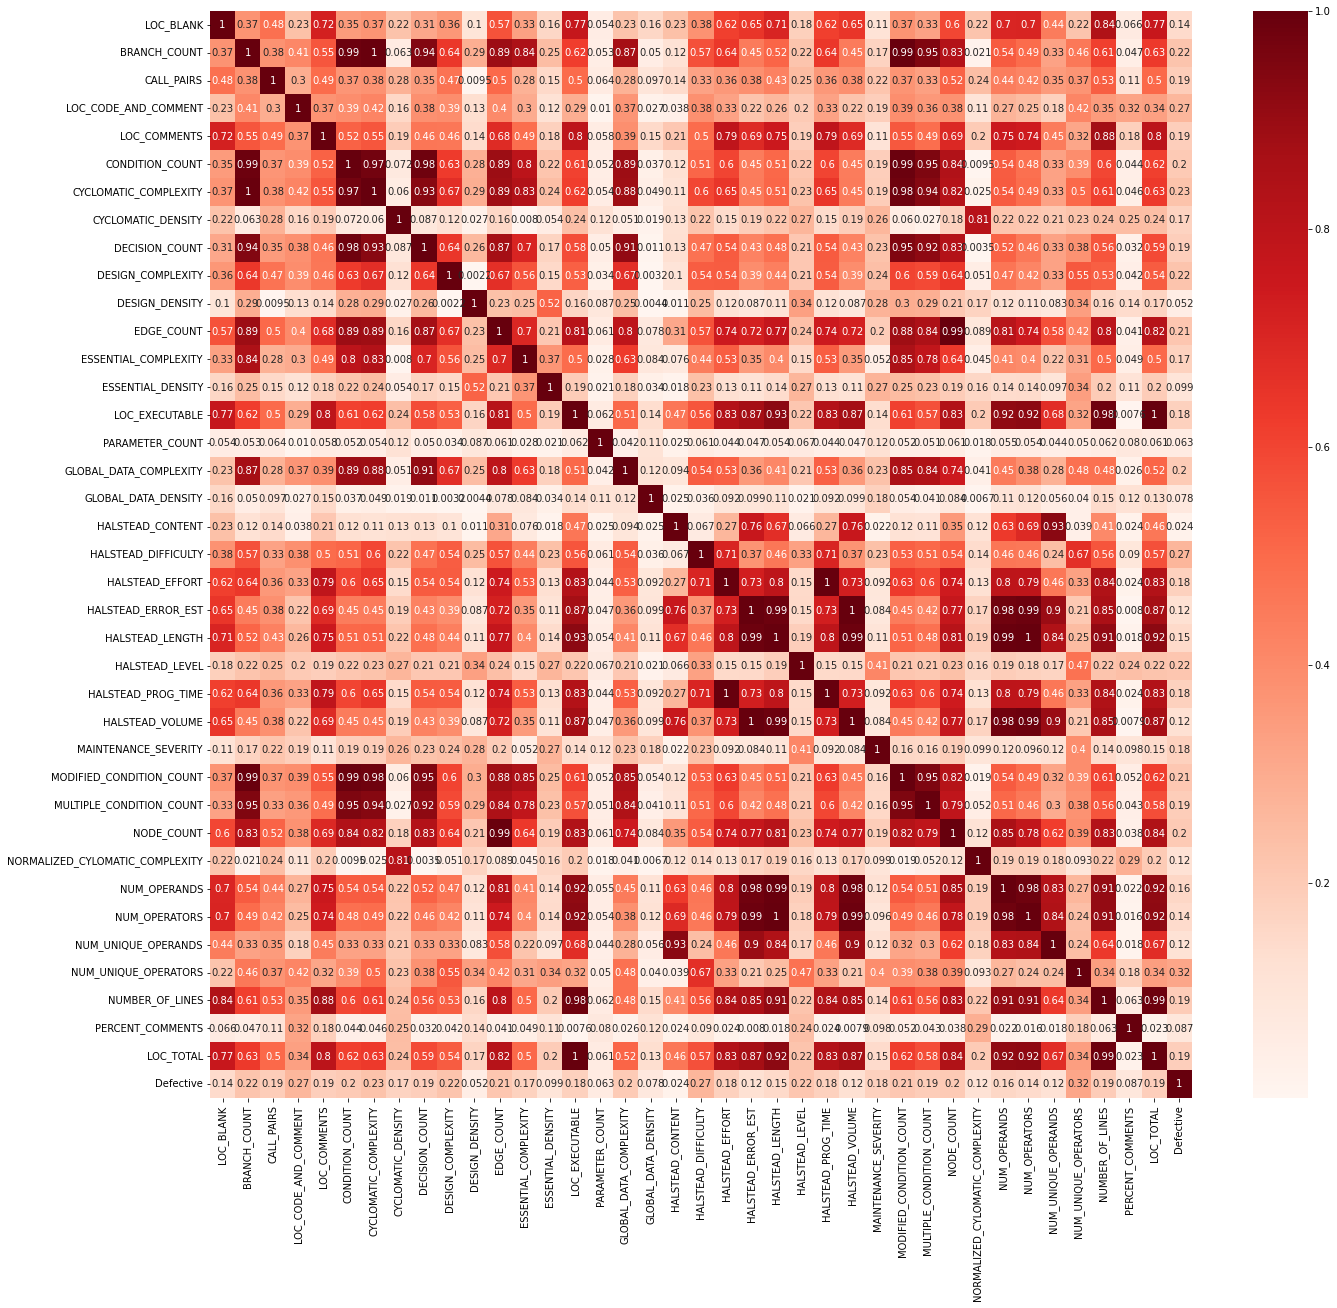

In [10]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [11]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUMBER_OF_LINES', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,...,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,PERCENT_COMMENTS,Defective
0,3.0,11.0,2.0,1.0,4.0,0.19,4.0,0.67,22.0,1.0,...,17.19,8142.30,0.16,0.06,0.17,0.14,21.0,19.0,13.89,1
1,6.0,17.0,2.0,0.0,3.0,0.16,4.0,0.44,26.0,6.0,...,24.94,32717.39,0.44,0.04,0.67,0.13,35.0,18.0,5.00,0
2,0.0,11.0,5.0,3.0,6.0,0.19,6.0,1.00,24.0,1.0,...,12.57,6662.86,0.18,0.08,0.17,0.15,21.0,11.0,23.68,0
3,1.0,17.0,2.0,1.0,17.0,0.14,5.0,0.56,28.0,7.0,...,47.03,63730.17,0.45,0.02,0.78,0.11,15.0,17.0,22.50,0
4,7.0,17.0,4.0,0.0,7.0,0.23,8.0,0.89,36.0,3.0,...,18.69,15868.32,0.28,0.05,0.33,0.16,24.0,13.0,14.89,0


In [12]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [14]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred=knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7315175097276264
MCC: 0.20547427236030086


Selected features for KNN

In [15]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS',
       'ESSENTIAL_COMPLEXITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT',
       'HALSTEAD_CONTENT', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST',
       'HALSTEAD_LEVEL', 'NUM_UNIQUE_OPERANDS'],
      dtype='object')

### Naive Bayes

In [16]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred=gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7315175097276264
MCC: 0.2082371151350669


Selected Features for Naive Bayes

In [17]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['BRANCH_COUNT', 'CYCLOMATIC_DENSITY', 'DESIGN_COMPLEXITY',
       'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY',
       'GLOBAL_DATA_COMPLEXITY', 'GLOBAL_DATA_DENSITY', 'HALSTEAD_DIFFICULTY',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_UNIQUE_OPERATORS',
       'PERCENT_COMMENTS'],
      dtype='object')

### Decision Tree

In [18]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred=dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7470817120622568
MCC: 0.32998559875586736


Selected features for Decision Tree

In [19]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'LOC_CODE_AND_COMMENT',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT',
       'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'PARAMETER_COUNT',
       'GLOBAL_DATA_COMPLEXITY', 'GLOBAL_DATA_DENSITY',
       'MAINTENANCE_SEVERITY'],
      dtype='object')

### Random Forest

In [20]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred=rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7762645914396887
MCC: 0.3981835212697815


Selected features for Random Forest

In [21]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'GLOBAL_DATA_DENSITY',
       'HALSTEAD_LEVEL', 'PERCENT_COMMENTS'],
      dtype='object')

### AdaBoost

In [22]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred=abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.7431906614785992
MCC: 0.26844038458368635


Selected features for AdaBoost Classifier

In [23]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'CALL_PAIRS', 'LOC_COMMENTS', 'CYCLOMATIC_DENSITY',
       'ESSENTIAL_DENSITY', 'PARAMETER_COUNT', 'GLOBAL_DATA_COMPLEXITY',
       'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_LEVEL',
       'MAINTENANCE_SEVERITY', 'NUM_UNIQUE_OPERANDS'],
      dtype='object')